#### SIPP1991 401K data

#### logs

5/15/2024 WL: template provided. TODO: write a brief intro to the data discussing the background, and the meaning of the variables; do a bit data summary and regression along the similar lines of ldw data.


**Semiparametic instrumental variable estimation of treatment response models, page 231-263 (Abadie, 2003).**

**Background:**

The challenge of estimating treatment effects when there's selection bias and unobserved confounding. Traditional methods fail when treatment assignment is endogenous - meaning people who receive treatment differ systematically from those who don't in ways that affect the outcome, and these differences aren't fully captured by observed variables.

Abadie developed semiparametric instrumental variable estimators that can identify and estimate treatment effects under weaker assumptions than traditional parametric IV methods. The key innovation is using instrumental variables in a more flexible, semiparametric framework that doesn't require strong functional form assumptions about the relationship between variables.

**Data Sample: Survey of Income and Program Participation (SIPP) of 1991**

Do 401(k) plans increase total household savings, or do they just shift money from other accounts?

Simply comparing 401(k) participants to non-participants is misleading because:
- People who choose to participate might already be better savers
- They might work at better companies
- They might have different preferences

Abadie's solution was to use whether the *employer offers* a 401(k) as an instrument for whether the employee *participates*  

The variables in the data set include:
\begin{align*}
%\begin{array}{ll}
\hline \text { Variable } & \quad \text { Description } \\
\hline \text { net tfa } &\quad  \text { Net total financial assets } \\
\text { e401 } &\quad  \text { = 1 if employers offers 401(k) } \\
\text { p401 } &\quad  \text { = 1 if the employee participates 401(k) } \\
\text { age } & \quad \text { age } \\
\text { inc } &\quad  \text { income } \\
\text { fsize } &\quad  \text { family size } \\
\text { educ } &\quad  \text { years of education }\\
\text { db } &\quad  \text { = 1 if indivudual has defined benefit pension } \\
\text { marr } &\quad \text { = 1 if married } \\
\text { twoearn } &\quad \text { = 1 if two-earner household } \\
\text { pira } &\quad \text { = 1 if individual participates in IRA } \\
\text { hown } &\quad \text { = 1 if home owner } \\
\hline
%\end{array}
\end{align*}

In [2]:
import io
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd
import seaborn as sns
import requests
from data_process import read

# Print the current working directory
print("Current working directory: {0}".format(os.getcwd()))

Current working directory: c:\Users\philh\Projects\One\401K


In [3]:
sns.set()
colors = sns.color_palette()
plt.rcParams['figure.figsize'] = 7., 5
sns.set(font_scale=1)
sns.set_style('whitegrid', {'axes.spines.top': True,
                            'axes.spines.bottom': True,
                            'axes.spines.left': True,
                            'axes.spines.right': True})

In [5]:
df = read(r"C:\Users\philh\Projects\One\401K\data\sipp1991.Rdata")
df.describe()

,nifa,net_tfa,tw,age,inc,fsize,educ,db,marr,twoearn,e401,p401,pira,hown
count,9.915000e+03,9.915000e+03,9.915000e+03,9915.000000,9915.000000,9915.000000,9915.000000,9915.000000,9915.000000,9915.000000,9915.000000,9915.000000,9915.000000,9915.000000
mean,1.392864e+04,1.805153e+04,6.381685e+04,41.060212,37200.623197,2.865860,13.206253,0.271004,0.604841,0.380837,0.371357,0.261624,0.242158,0.635199
std,5.490488e+04,6.352250e+04,1.115297e+05,10.344505,24774.288006,1.538937,2.810382,0.444500,0.488909,0.485617,0.483192,0.439541,0.428411,0.481399
min,0.000000e+00,-5.023020e+05,-5.023020e+05,25.000000,-2652.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000e+02,-5.000000e+02,3.291500e+03,32.000000,19413.000000,2.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.635000e+03,1.499000e+03,2.510000e+04,40.000000,31476.000000,3.000000,12.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,8.765500e+03,1.652450e+04,8.148750e+04,48.000000,48583.500000,4.000000,16.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000
max,1.430298e+06,1.536798e+06,2.029910e+06,64.000000,242124.000000,13.000000,18.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Sample Overview:

In [ ]:
print("=== SIPP 1991 401(k) Sample ===")
print(f"Total households: {len(df):,}")
print(f"Age range: {df['age'].min()}-{df['age'].max()} years")
print(f"Income range: ${df['inc'].min():,.0f} - ${df['inc'].max():,.0f}")
print(f"Average net financial assets: ${df['net_tfa'].mean():,.0f}")

=== SIPP 1991 401(k) Sample ===
Total households: 9,915
Age range: 25-64 years
Income range: $-2,652 - $242,124
Average net financial assets: $18,052


The Instrumental Variable Setup:

In [8]:
print("=== The Instrumental Variable Strategy ===")
print("Employer Offering → Employee Participation → Savings Outcomes")
print()
cross_tab = pd.crosstab(df['e401'], df['p401'], margins=True)
print("Employer Offering vs Employee Participation:")
print(cross_tab)
print()
print(f"Key insight: {df[df['e401']==1]['p401'].mean():.1%} of employees participate when offered")
print(f"But only {df['e401'].mean():.1%} of employers offer 401(k) plans")

=== The Instrumental Variable Strategy ===
Employer Offering → Employee Participation → Savings Outcomes

Employer Offering vs Employee Participation:
p401     0     1   All
e401                  
0     6233     0  6233
1     1088  2594  3682
All   7321  2594  9915

Key insight: 70.5% of employees participate when offered
But only 37.1% of employers offer 401(k) plans


Why We Need an Instrument (The Selection Problem):

In [ ]:
print("=== The Selection Problem ===")
participants = df[df['p401']==1]
non_participants = df[df['p401']==0]

print("401(k) Participants vs Non-Participants:")
print(f"Average income: ${participants['inc'].mean():,.0f} vs ${non_participants['inc'].mean():,.0f}")
print(f"Average age: {participants['age'].mean():.1f} vs {non_participants['age'].mean():.1f}")
print(f"College educated: {(participants['educ']>=16).mean():.1%} vs {(non_participants['educ']>=16).mean():.1%}")
print()
print("Participants are systematically different! Simple comparison would be biased.")

=== The Selection Problem ===
401(k) Participants vs Non-Participants:
Average income: $49,367 vs $32,890
Average age: 41.5 vs 40.9
College educated: 32.9% vs 22.3%

Participants are systematically different! Simple comparison would be biased.


# Statistical Analysis

#### Naive Comparison

In [13]:
# The biased estimate
print("=== Naive Comparison (BIASED) ===")
naive_diff = participants['net_tfa'].mean() - non_participants['net_tfa'].mean()
print(f"Raw difference in net assets: ${naive_diff:,.0f}")
print("But this confounds selection effects with treatment effects!")

=== Naive Comparison (BIASED) ===
Raw difference in net assets: $27,372
But this confounds selection effects with treatment effects!


#### Regression with Controls:

In [16]:
import statsmodels.api as sm

X = df[["e401", "p401", "age", "inc", "educ", "fsize", "db", "marr", "twoearn", "pira", "hown"]]
X = sm.add_constant(X)  # adds intercept
y = df["net_tfa"]
print("=== OLS with Controls ===")

model = sm.OLS(y, X)
results = model.fit()

print(f"401(k) participation effect: ${results.params['p401']:,.0f}")
print(f"Standard error: ${results.bse['p401']:,.0f}")
print(f"P-value: {results.pvalues['p401']:.3f}")
print(f"95% Confidence interval: ${results.conf_int().loc['p401', 0]:,.0f} to ${results.conf_int().loc['p401', 1]:,.0f}")


=== OLS with Controls ===
401(k) participation effect: $15,541
Standard error: $2,027
P-value: 0.000
95% Confidence interval: $11,568 to $19,514


#### Reduced Form (Intent-to-Treat):

In [17]:
print("=== Reduced Form: Effect of Employer Offering ===")
X_reduced = df[["e401", "age", "inc", "educ", "fsize", "db", "marr", "twoearn", "pira", "hown"]]
X_reduced = sm.add_constant(X_reduced)
model_reduced = sm.OLS(df["net_tfa"], X_reduced).fit()
print(f"Employer offering effect: ${model_reduced.params['e401']:,.0f}")

=== Reduced Form: Effect of Employer Offering ===
Employer offering effect: $5,896


#### First Stage: How Strong The Instrument Is

In [18]:
print("=== First Stage: Employer Offering → Participation ===")
model_first = sm.OLS(df["p401"], X_reduced).fit()
print(f"Employer offering increases participation by: {model_first.params['e401']:.1%}")
print(f"F-statistic: {model_first.fvalue:.1f} (>10 suggests strong instrument)")

=== First Stage: Employer Offering → Participation ===
Employer offering increases participation by: 69.3%
F-statistic: 1533.6 (>10 suggests strong instrument)


# Visualizations

#### The Key Relationship:

Text(0, 0.5, 'Net Financial Assets ($)')

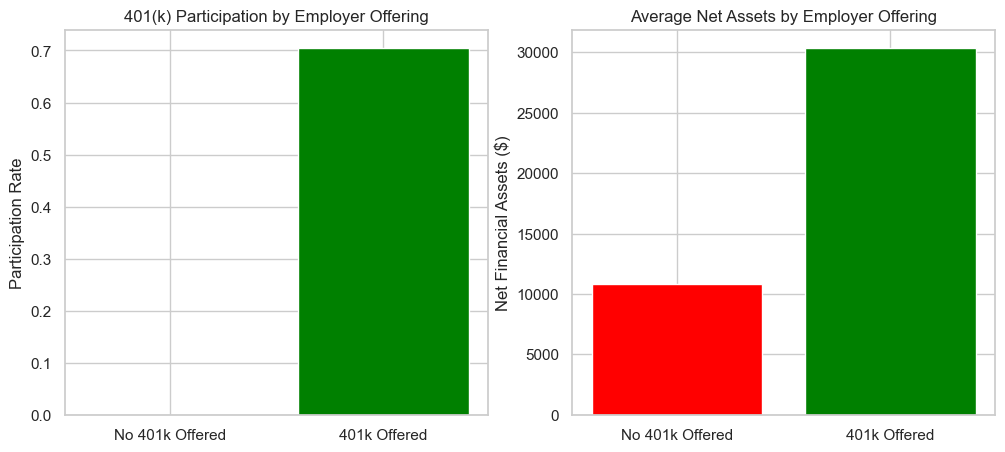

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1: Participation rates by offering
offer_participation = df.groupby('e401')['p401'].mean()
axes[0].bar(['No 401k Offered', '401k Offered'], offer_participation, color=['red', 'green'])
axes[0].set_title('401(k) Participation by Employer Offering')
axes[0].set_ylabel('Participation Rate')

# Plot 2: Average assets by offering (reduced form)
offer_assets = df.groupby('e401')['net_tfa'].mean()
axes[1].bar(['No 401k Offered', '401k Offered'], offer_assets, color=['red', 'green'])
axes[1].set_title('Average Net Assets by Employer Offering')
axes[1].set_ylabel('Net Financial Assets ($)')

In [23]:
# statistical tests
from scipy import stats

# Test for differences in means
statistic, p_value = stats.ttest_ind(
    df[df['e401']==1]['net_tfa'], 
    df[df['e401']==0]['net_tfa']
)
print(f"T-test for difference in assets by employer offering:")
print(f"T-statistic: {statistic:.3f}, P-value: {p_value:.3f}")

T-test for difference in assets by employer offering:
T-statistic: 14.980, P-value: 0.000


# Economic Interpretation

In [24]:
print("=== Economic Interpretation ===")
print(f"Main finding: Employer 401(k) offering increases net financial assets by ${model_reduced.params['e401']:,.0f}")
print(f"This represents a {model_reduced.params['e401']/df['net_tfa'].mean()*100:.1f}% increase over the sample mean")
print()
print("Policy implication: Expanding 401(k) access could significantly boost household savings")

=== Economic Interpretation ===
Main finding: Employer 401(k) offering increases net financial assets by $5,896
This represents a 32.7% increase over the sample mean

Policy implication: Expanding 401(k) access could significantly boost household savings
